<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/Horoscopes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Horoscopes

![](https://www.adweek.com/wp-content/uploads/2021/03/spring-horoscopes-marketers-2021.jpg)

# Install

In [1]:
!pip install transformers datasets

# Setup

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from collections import Counter

import gensim.downloader as api

import tensorflow as tf
import tensorflow_hub as hub

import nltk
nltk.download('punkt')
from nltk.tokenize.treebank import TreebankWordTokenizer

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Parameters

In [3]:
SIGNS = ['aries', 'taurus', 'gemini', 'cancer', 'leo', 'virgo', 'libra', 'scorpio', 'sagittarius', 'capricorn', 'aquarius', 'pisces']
DATES = pd.date_range(start='2021-01-01', end='2022-01-01', freq='D').strftime('%Y%m%d')

# Scrape
* Roughly 15-20 minutes to scrape

In [4]:
def extract(html):
  text = re.findall('c-fuji-batcave\)">(.+) <a href', html)
  return text

SCRAPE = False
if SCRAPE:
  results = []
  for sign in SIGNS:
    print(sign)
    for date in DATES:
      page = f'https://www.yahoo.com/lifestyle/horoscope/{sign}/daily-{date}/html'
      response = requests.get(page)
      horoscope = extract(response.text)
      result = (sign, date, horoscope)
      results.append(result)

  horoscope_df = pd.DataFrame(results)
  horoscope_df.columns = ['sign', 'date', 'text']
  horoscope_df['text'] = horoscope_df.text.str[0]
  horoscope_df.to_csv('horoscope.csv', index=False)

# Load
* Manually upload file 
* Read scraped dataframe

In [5]:
horoscope_df = pd.read_csv('horoscope.csv')
horoscope_df = horoscope_df[horoscope_df.text.notnull()]
horoscope_df

,sign,date,text
0,aries,20210101,"Your bold action makes life a lot better, and ..."
1,aries,20210102,"Today is a fiery day all around, so make sure ..."
2,aries,20210103,Try something healthy and fun today: a new kin...
3,aries,20210104,Someone needs help. Can you give them what the...
4,aries,20210105,You need to listen closely today. There's one ...
...,...,...,...
4387,pisces,20211228,Something small triggers an emotional avalanch...
4388,pisces,20211229,You're not feeling totally confident about a c...
4389,pisces,20211230,Take greater care than usual with legal docume...
4390,pisces,20211231,"Someone has a different opinion from you, but ..."


# Baseline

In [6]:
results_df = pd.DataFrame(columns=['Accuracy'])

In [7]:
results_df.loc['Baseline'] = [1 / 12]

# Naive Bayes

## Vectorize

In [8]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(horoscope_df.text)

CountVectorizer(stop_words='english')

## Train - Test

In [9]:
x = horoscope_df.text
encoder = LabelEncoder()
y = encoder.fit_transform(horoscope_df.sign)

train, test, y_train, y_test = train_test_split(x, y, random_state=66)
X_train = vectorizer.transform(train)
X_test  = vectorizer.transform(test)

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(3279, 5880) (3279,)
(1093, 5880) (1093,)


## Model

In [10]:
model = MultinomialNB()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
results_df.loc['NaiveBayes'] = [score]
print('Model', score)

Model 0.15187557182067704


## Predict

In [11]:
encoder.classes_

array(['aquarius', 'aries', 'cancer', 'capricorn', 'gemini', 'leo',
       'libra', 'pisces', 'sagittarius', 'scorpio', 'taurus', 'virgo'],
      dtype=object)

              precision    recall  f1-score   support

    aquarius       0.15      0.20      0.17        83
       aries       0.16      0.10      0.12       103
      cancer       0.20      0.19      0.20        93
   capricorn       0.15      0.15      0.15        94
      gemini       0.15      0.21      0.18        90
         leo       0.13      0.10      0.11        89
       libra       0.15      0.15      0.15        99
      pisces       0.12      0.11      0.11        94
 sagittarius       0.14      0.11      0.12        95
     scorpio       0.21      0.22      0.22        85
      taurus       0.15      0.16      0.16        87
       virgo       0.11      0.14      0.12        81

    accuracy                           0.15      1093
   macro avg       0.15      0.15      0.15      1093
weighted avg       0.15      0.15      0.15      1093



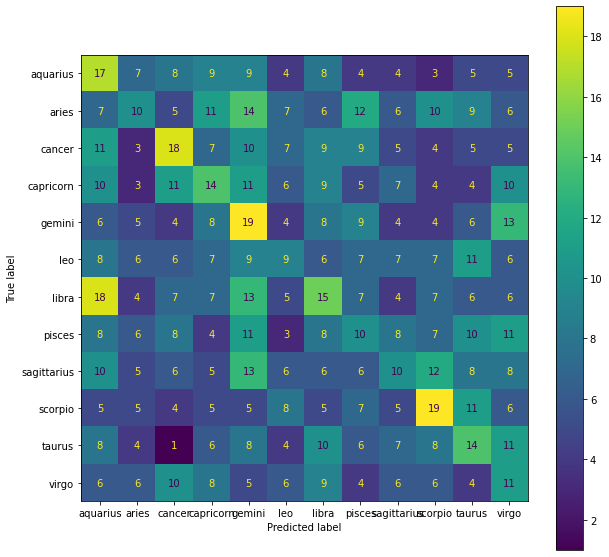

In [12]:
pred = model.predict(X_test)
fig, ax = plt.subplots(figsize=(10,10))
print(classification_report(y_test, pred, target_names=encoder.classes_))
cm = confusion_matrix(y_test, pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
cmd.plot(ax=ax);

## Correct

In [13]:
horoscope_df.loc[test[pred == y_test].index]

,sign,date,text
3439,capricorn,20210526,"Nothing seems to be working out for you today,..."
2115,virgo,20211013,It's all too easy for you to criticize instead...
524,taurus,20210608,"You aren't quite feeling like yourself today, ..."
1008,gemini,20211004,Your people are having a hard time reading you...
702,taurus,20211203,Your passions are fully engaged today even if ...
...,...,...,...
2221,libra,20210126,Someone in your life needs help with their sty...
1766,leo,20211030,Sometimes your social energy needs to recharge...
1210,cancer,20210423,"Your left brain is more active than usual, and..."
3141,sagittarius,20210802,You're extremely thoughtful today -- but your ...


## Entry

In [14]:
your_horoscope = 'Throw a party with friends'
pred = model.predict(vectorizer.transform([your_horoscope]))
encoder.inverse_transform(pred)

array(['libra'], dtype=object)

In [15]:
your_horoscope = 'Stay in bed all day'
pred = model.predict(vectorizer.transform([your_horoscope]))
encoder.inverse_transform(pred)

array(['sagittarius'], dtype=object)

# Random Forest
* Bag of Words + More Complex Model

## Vectorize

In [16]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(horoscope_df.text)

CountVectorizer(stop_words='english')

## Train Test

In [17]:
x = horoscope_df.text
encoder = LabelEncoder()
y = encoder.fit_transform(horoscope_df.sign)

train, test, y_train, y_test = train_test_split(x, y, random_state=66)
X_train = vectorizer.transform(train)
X_test  = vectorizer.transform(test)

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(3279, 5880) (3279,)
(1093, 5880) (1093,)


## Model

In [18]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
results_df.loc['RandomForest'] = [score]
print('Model', score)

Model 0.14364135407136322


## Predict

              precision    recall  f1-score   support

    aquarius       0.10      0.16      0.12        83
       aries       0.13      0.09      0.11       103
      cancer       0.12      0.15      0.14        93
   capricorn       0.11      0.10      0.10        94
      gemini       0.15      0.16      0.15        90
         leo       0.15      0.12      0.14        89
       libra       0.20      0.20      0.20        99
      pisces       0.12      0.14      0.13        94
 sagittarius       0.15      0.13      0.14        95
     scorpio       0.18      0.22      0.20        85
      taurus       0.17      0.16      0.17        87
       virgo       0.14      0.11      0.12        81

    accuracy                           0.14      1093
   macro avg       0.14      0.14      0.14      1093
weighted avg       0.15      0.14      0.14      1093



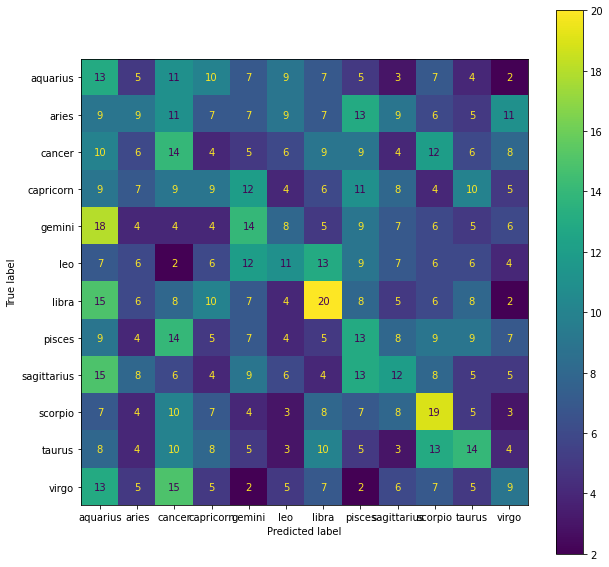

In [19]:
pred = model.predict(X_test)
fig, ax = plt.subplots(figsize=(10,10))
print(classification_report(y_test, pred, target_names=encoder.classes_))
cm = confusion_matrix(y_test, pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
cmd.plot(ax=ax);

# Word Embeddings

## Load

In [20]:
w2v_model = api.load("glove-wiki-gigaword-50")
w2v_tokenizer = TreebankWordTokenizer()

## Parse

In [21]:
UNK = np.array([0.] * 50)

def awe_embedding(model, tokenizer, sentence):
  tokens = tokenizer.tokenize(sentence)
  for token in tokens:
    embedding = []
    try:
      vector = model.get_vector(token.lower())
      embedding.append(vector)
    except:
      pass
    
    if len(embedding) == 0:
      return UNK
    
    return np.mean(embedding, axis=0)

## Train - Test

In [22]:
x = horoscope_df.text
encoder = LabelEncoder()
y = encoder.fit_transform(horoscope_df.sign)
train, test, y_train, y_test = train_test_split(x, y, random_state=66)

## Embed

In [23]:
X_train = []
for doc in train:
  embedding = awe_embedding(w2v_model, w2v_tokenizer, doc)
  X_train.append(embedding)

X_test = []
for doc in test:
  embedding = awe_embedding(w2v_model, w2v_tokenizer, doc)
  X_test.append(embedding)


In [24]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(3279, 50)
(1093, 50)


## Model

In [25]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['GloVe[50]'] = [score]
print('Model', score)

Model 0.09515096065873742


# Sentence Embeddings

## Load

In [26]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4' 
model      = hub.load(module_url)

## Train - Test

In [27]:
x = horoscope_df.text
encoder = LabelEncoder()
y = encoder.fit_transform(horoscope_df.sign)

train, test, y_train, y_test = train_test_split(x, y, random_state=66)

## Embed

In [28]:
X_train = model(train)
X_test  = model(test)

X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(3279, 512) (3279,)
(1093, 512) (1093,)


## Model

In [29]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['UniversalSentenceEncoder'] = [score]
print('Model', score)

Model 0.12351326623970722


# BERT

## Load

In [30]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=12)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Train - Test

In [31]:
x = list(horoscope_df.text)
encoder = LabelEncoder()
y = encoder.fit_transform(horoscope_df.sign)
train, test = train_test_split(pd.DataFrame({'text':x, 'label':y}), random_state=66)
y_train = train['label']
y_test = test['label']

## Dataset

In [32]:
dataset_train = Dataset.from_pandas(train)
dataset_test  = Dataset.from_pandas(test)

## Tokenize

In [33]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=100)

tokenized_train = dataset_train.map(tokenize_function, batched=True)
tokenized_test  = dataset_test.map(tokenize_function, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Trainer

In [34]:
batch_size = 16
logging_steps = len(tokenized_train) // batch_size
training_args = TrainingArguments('test_trainer',
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  logging_steps=logging_steps)

trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=tokenized_train, 
                  eval_dataset=tokenized_test)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3279
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 410


Epoch,Training Loss,Validation Loss
1,2.507200,2.485575
2,2.468900,2.479800


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1093
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1093
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=410, training_loss=2.488019819957454, metrics={'train_runtime': 83.0312, 'train_samples_per_second': 78.982, 'train_steps_per_second': 4.938, 'total_flos': 337038520536000.0, 'train_loss': 2.488019819957454, 'epoch': 2.0})

## Predict

In [35]:
pred = trainer.predict(tokenized_test)
y_hat = pred.predictions.argmax(axis=1)
score = accuracy_score(y_test, y_hat)
results_df.loc['BERT'] = [score]
print('Model', score)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Prediction *****
  Num examples = 1093
  Batch size = 16


Model 0.10064043915827996


              precision    recall  f1-score   support

    aquarius       0.11      0.30      0.16        83
       aries       0.09      0.15      0.11       103
      cancer       0.09      0.14      0.11        93
   capricorn       0.13      0.02      0.04        94
      gemini       0.11      0.02      0.04        90
         leo       0.13      0.13      0.13        89
       libra       0.00      0.00      0.00        99
      pisces       0.19      0.09      0.12        94
 sagittarius       0.00      0.00      0.00        95
     scorpio       0.11      0.07      0.09        85
      taurus       0.07      0.01      0.02        87
       virgo       0.08      0.32      0.13        81

    accuracy                           0.10      1093
   macro avg       0.09      0.10      0.08      1093
weighted avg       0.09      0.10      0.08      1093



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


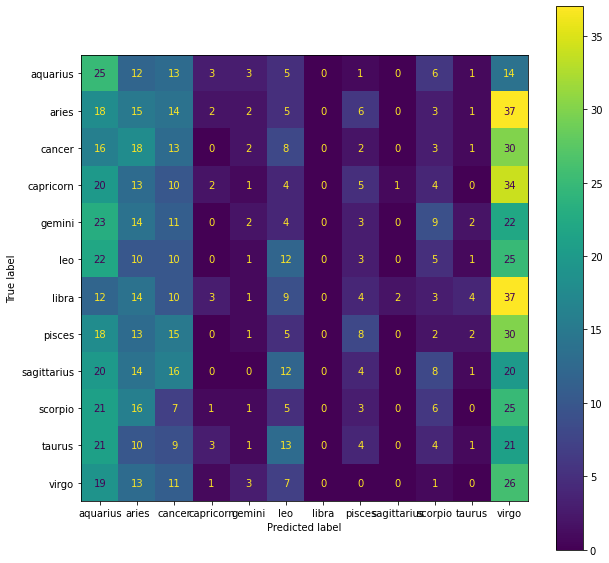

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
print(classification_report(y_test, y_hat, target_names=encoder.classes_))
cm = confusion_matrix(y_test, y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
cmd.plot(ax=ax);

In [37]:
Counter(y_hat)

Counter({0: 235,
         1: 162,
         2: 139,
         3: 15,
         4: 18,
         5: 89,
         7: 43,
         8: 3,
         9: 54,
         10: 14,
         11: 321})

# Comparison

In [38]:
results_df.sort_values('Accuracy', ascending=False)

,Accuracy
NaiveBayes,0.151876
RandomForest,0.143641
UniversalSentenceEncoder,0.123513
BERT,0.100640
GloVe[50],0.095151
Baseline,0.083333


# More Investigation
* Date - Does it help with features?
* More - Data?